This notebook implements a diagonalization procedure to determine the diagonalizing basis of the erf kernel. 

In [ ]:
import numpy as np
from scipy.special import eval_hermitenorm as He
from scipy.special import erf
from scipy.linalg import eigh
from tqdm import tqdm

# --- Configuration Parameters ---
D = 625          # Dimensionality of the space
S_OUTER = 20000  # Number of Monte Carlo samples for the outer integral (w)
S_INNER = 1000   # Number of Monte Carlo samples for the inner integral (z)

# --- Parameters for the Anisotropic Covariance ---
L_V = 1.0        # User-defined parameter
N_SAMPLES = 128  # User-defined parameter 'n'
# NOTE: The formula for 'b' was given as b = 1/(d + b*...).
# This is interpreted as the 'b' in the denominator being a separate parameter.
# We name it B_PARAM to avoid confusion.
B_PARAM = 4 / ( 3 * np.pi)

# For reproducibility
np.random.seed(42)

# --- Define the special target direction v ---
v_target = np.zeros(D)
v_target[0] = 1.0

def get_covariance_params(d, l_v_param, n_samples, b_param):
    """Calculates the covariance parameters 'a' and 'b'."""
    a = 1.0 / d
    b = 1.0 / (d + b_param * l_v_param * 1 / n_samples)
    print(f"Calculated Covariance Parameters: a = {a:.6f}, b = {b:.6f}")
    return a, b

def sample_w_anisotropic(n_samples, d, a, b, v):
    """
    Generates samples w ~ N(0, Sigma) where Sigma = a*I + b*v*v^T.
    This is much more efficient than forming Sigma and using a generic MVN sampler.
    """
    # 1. Start with standard normal samples
    z = np.random.randn(n_samples, d)
    
    # 2. Project z onto the special direction v
    # z_dot_v will have shape (n_samples, 1)
    z_dot_v = np.dot(z, v).reshape(-1, 1)
    
    # 3. Apply the transformation formula
    # w = sqrt(a)*z + (sqrt(a+b) - sqrt(a))*(z.v)*v
    sqrt_a = np.sqrt(a)
    sqrt_a_plus_b = np.sqrt(a + b)
    
    # The term (z.v)*v requires broadcasting v to match the shape of z_dot_v
    # v is (d,), z_dot_v is (n_samples, 1). Result is (n_samples, d).
    w = sqrt_a * z + (sqrt_a_plus_b - sqrt_a) * z_dot_v * v
    
    return w

def compute_inner_term_A(k, basis_vec, w):
    """
    Computes A_k(w) = E_z[ He_k(basis_vec . z) * erf(w . z) ]
    This function remains unchanged as its logic is independent of how w was generated.
    """
    w_dot_basis = np.dot(basis_vec, w)
    w_perp_norm_sq = np.dot(w, w) - w_dot_basis**2
    w_perp_norm = np.sqrt(max(0, w_perp_norm_sq))

    z_parallel = np.random.randn(S_INNER)
    z_perp = np.random.randn(S_INNER)

    he_vals = He(k, z_parallel)
    erf_args = w_dot_basis * z_parallel + w_perp_norm * z_perp
    erf_vals = erf(erf_args)

    return np.mean(he_vals * erf_vals)

def compute_matrix_element(n, m, basis_vec_n, basis_vec_m, w_samples):
    """
    Computes K_nm = E_w[ A_n(w, basis_vec_n) * A_m(w, basis_vec_m) ]
    This function now takes the pre-sampled w vectors as an argument.
    """
    product_sum = 0.0
    
    print(f"  Calculating K_{n}{m} for directions ({basis_vec_n[0]:.1f}, {basis_vec_m[0]:.1f}, ...)")
    for w in tqdm(w_samples, desc=f"  K_{n}{m}"):
        A_n_w = compute_inner_term_A(n, basis_vec_n, w)
        # If basis vectors are the same, no need to recompute A_m
        if n == m and np.array_equal(basis_vec_n, basis_vec_m):
            A_m_w = A_n_w
        else:
            A_m_w = compute_inner_term_A(m, basis_vec_m, w)
        product_sum += A_n_w * A_m_w
        
    return product_sum / S_OUTER

def compute_and_diagonalize_block(basis_vec, w_samples):
    """
    Computes and diagonalizes the 2x2 matrix for a given direction.
    """
    K_block = np.zeros((2, 2))
    
    K_block[0, 0] = compute_matrix_element(1, 1, basis_vec, basis_vec, w_samples)
    K_block[0, 1] = compute_matrix_element(1, 3, basis_vec, basis_vec, w_samples)
    K_block[1, 0] = K_block[0, 1]
    K_block[1, 1] = compute_matrix_element(3, 3, basis_vec, basis_vec, w_samples)
    
    eigenvalues, eigenvectors = eigh(K_block)
    
    return K_block, eigenvalues, eigenvectors

def main():
    """ Main execution function. """
    print(f"Starting computation for d={D}, S_outer={S_OUTER}, S_inner={S_INNER}")
    
    # 1. Calculate covariance parameters and generate w samples ONCE
    a, b = get_covariance_params(D, L_V, N_SAMPLES, B_PARAM)
    print("Generating anisotropic w samples...")
    w_samples = sample_w_anisotropic(S_OUTER, D, a, b, v_target)
    print("...done.")

    # 2. Define the orthonormal basis for the perpendicular block
    u_perp = np.zeros(D)
    u_perp[1] = 1.0

    # 3. Analyze the Parallel Block (aligned with v_target)
    print("\n--- Analyzing Parallel Block (non-degenerate) ---")
    K_parallel, lambdas_p, evecs_p = compute_and_diagonalize_block(v_target, w_samples)
    
    # 4. Analyze the Perpendicular Block (aligned with u_perp)
    print(f"\n--- Analyzing Perpendicular Block ({D-1}-fold degenerate) ---")
    K_perp, lambdas_q, evecs_q = compute_and_diagonalize_block(u_perp, w_samples)

    # 5. Print the final results
    print("\n" + "="*50)
    print("                RESULTS SUMMARY")
    print("="*50)
    
    print("\nParallel Block (aligned with target direction v):")
    print("Matrix K_parallel:")
    print(K_parallel)
    print("\nEigenvalues (non-degenerate):")
    print(f"  lambda_p1 = {lambdas_p[0]:.6f}")
    print(f"  lambda_p2 = {lambdas_p[1]:.6f}")
    print("\nEigenvectors (coefficients for [He1, He3]):")
    print(f"  evec_p1 = {evecs_p[:, 0]}")
    print(f"  evec_p2 = {evecs_p[:, 1]}")

    print("\n" + "-"*50)

    print(f"\nPerpendicular Block (orthogonal to v, {D-1}-fold degenerate):")
    print("Matrix K_perp:")
    print(K_perp)
    print(f"\nEigenvalues ({D-1}-fold degenerate each):")
    print(f"  lambda_q1 = {lambdas_q[0]:.6f}")
    print(f"  lambda_q2 = {lambdas_q[1]:.6f}")
    print("\nEigenvectors (coefficients for [He1, He3]):")
    print(f"  evec_q1 = {evecs_q[:, 0]}")
    print(f"  evec_q2 = {evecs_q[:, 1]}")
    print("="*50)


if __name__ == "__main__":
    main()

Starting computation for d=625, S_outer=20000, S_inner=1000
Calculated Covariance Parameters: a = 0.001600, b = 0.001600
Generating anisotropic w samples...
...done.

--- Analyzing Parallel Block (non-degenerate) ---
  Calculating K_11 for directions (1.0, 1.0, ...)


  K_11: 100%|██████████| 20000/20000 [00:01<00:00, 17092.16it/s]


  Calculating K_13 for directions (1.0, 1.0, ...)


  K_13: 100%|██████████| 20000/20000 [00:02<00:00, 8929.71it/s]


  Calculating K_33 for directions (1.0, 1.0, ...)


  K_33: 100%|██████████| 20000/20000 [00:01<00:00, 16909.21it/s]



--- Analyzing Perpendicular Block (624-fold degenerate) ---
  Calculating K_11 for directions (0.0, 0.0, ...)


  K_11: 100%|██████████| 20000/20000 [00:01<00:00, 17006.93it/s]


  Calculating K_13 for directions (0.0, 0.0, ...)


  K_13: 100%|██████████| 20000/20000 [00:02<00:00, 8929.89it/s]


  Calculating K_33 for directions (0.0, 0.0, ...)


  K_33: 100%|██████████| 20000/20000 [00:01<00:00, 16866.77it/s]


                RESULTS SUMMARY

Parallel Block (aligned with target direction v):
Matrix K_parallel:
[[ 1.78565599e-03 -9.11440307e-06]
 [-9.11440307e-06  2.81132598e-03]]

Eigenvalues (non-degenerate):
  lambda_p1 = 0.001786
  lambda_p2 = 0.002811

Eigenvectors (coefficients for [He1, He3]):
  evec_p1 = [-0.99996053 -0.00888524]
  evec_p2 = [-0.00888524  0.99996053]

--------------------------------------------------

Perpendicular Block (orthogonal to v, 624-fold degenerate):
Matrix K_perp:
[[ 1.14577692e-03 -7.75854834e-06]
 [-7.75854834e-06  2.78324785e-03]]

Eigenvalues (624-fold degenerate each):
  lambda_q1 = 0.001146
  lambda_q2 = 0.002783

Eigenvectors (coefficients for [He1, He3]):
  evec_q1 = [-0.99998878 -0.00473797]
  evec_q2 = [-0.00473797  0.99998878]


Starting parallel computation on 22 cores for 1001 l_V points...


Scanning l_V: 100%|██████████| 1001/1001 [01:00<00:00, 16.66it/s]



Parallel computation finished in 63.18 seconds.
986/1001 points computed successfully.
Stabilizing eigensystem results...


Stabilizing: 100%|██████████| 986/986 [00:00<00:00, 33222.88it/s]

All computed data saved to 'eigensystem_scan_data_parallel.npz'


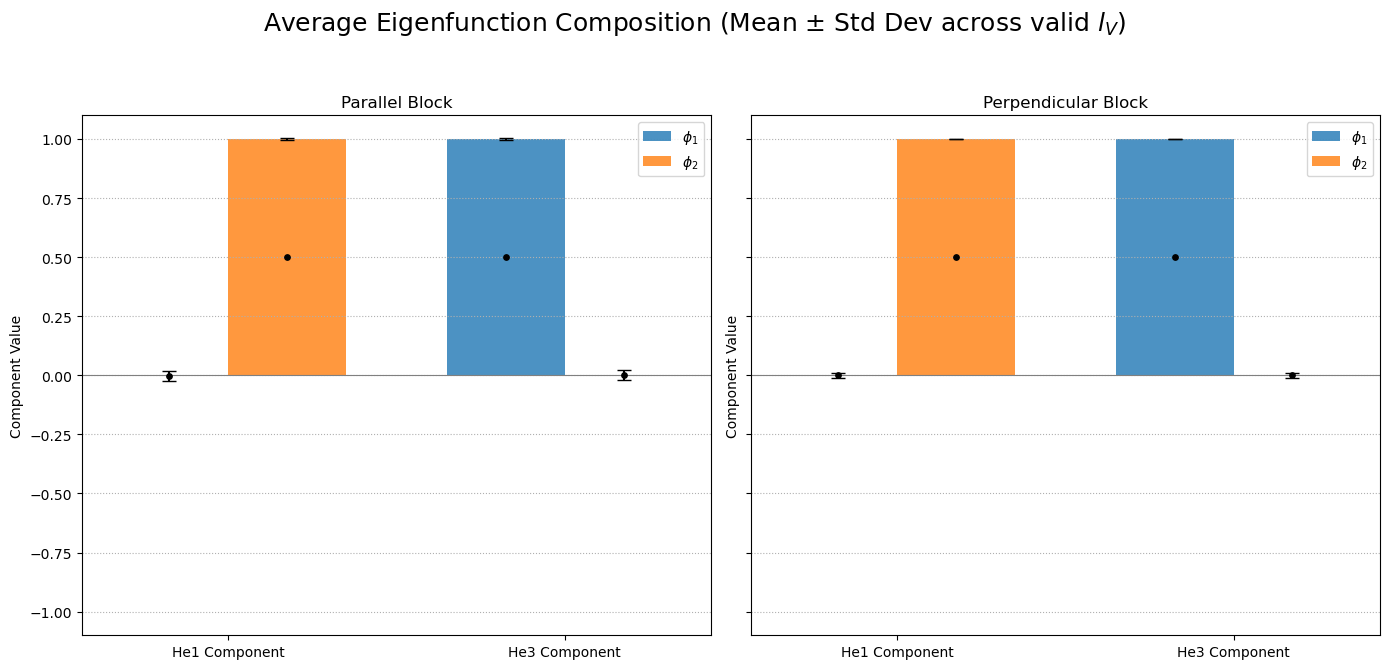

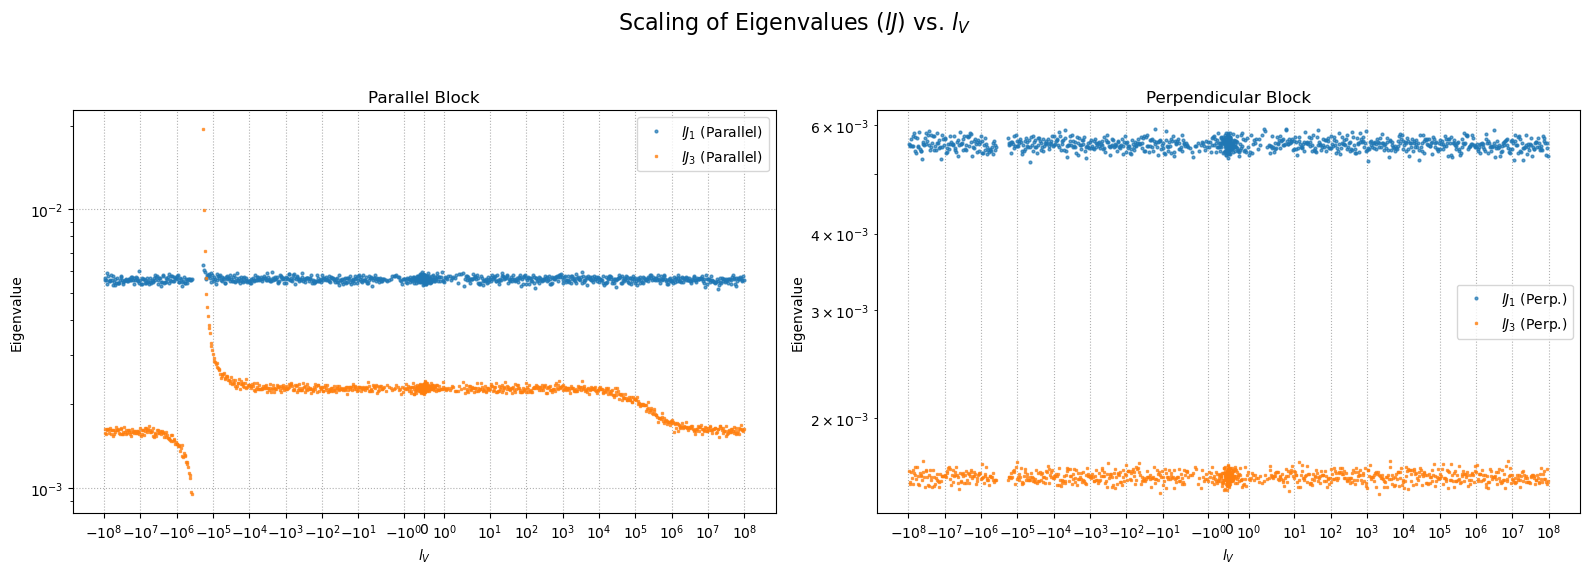

In [11]:
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# --- Import necessary functions ---
from scipy.special import eval_hermitenorm as He, erf
from scipy.linalg import eigh
from joblib import Parallel, delayed

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# 1. CONFIGURATION
# =============================================================================
class Config:
    D = 625
    B_PARAM = 4 / (3 * np.pi)
    N_SAMPLES_PARAM = 128
    S_OUTER = 5000
    S_INNER = 500
    L_V_MIN = -1e8
    L_V_MAX = 1e8
    NUM_ANALYSIS_POINTS = 1000
    NUM_CORES = 22 # Set to the number of CPU cores to use
    OUTPUT_FILENAME = 'eigensystem_scan_data_parallel.npz'

# =============================================================================
# 2. CORE COMPUTATIONAL FUNCTIONS
# =============================================================================

def get_covariance_params(l_v, d, n_samples, b_param):
    a = 1.0 / d
    denominator = d + b_param * l_v * (1 / n_samples)
    if np.abs(denominator) < 1e-9: return None, None
    b = 1.0 / denominator
    if a + b < 0: return None, None
    return a, b

def sample_w_anisotropic(n_samples, d, a, b, v):
    z = np.random.randn(n_samples, d)
    z_dot_v = np.dot(z, v).reshape(-1, 1)
    sqrt_a = np.sqrt(a); sqrt_a_plus_b = np.sqrt(a + b)
    w = sqrt_a * z + (sqrt_a_plus_b - sqrt_a) * z_dot_v * v
    return w

def compute_inner_term_A(k, basis_vec, w, s_inner):
    w_dot_basis = np.dot(basis_vec, w)
    w_perp_norm_sq = np.dot(w, w) - w_dot_basis**2
    w_perp_norm = np.sqrt(max(0, w_perp_norm_sq))
    z_parallel = np.random.randn(s_inner)
    z_perp = np.random.randn(s_inner)
    he_vals = He(k, z_parallel)
    erf_args = w_dot_basis * z_parallel + w_perp_norm * z_perp
    erf_vals = erf(erf_args)
    return np.mean(he_vals * erf_vals)

def process_single_l_v(l_v, config):
    """
    This is the core unit of work for a single l_V point.
    It computes the raw, unstabilized eigensystems for both blocks.
    """
    try:
        v_parallel = np.zeros(config.D); v_parallel[0] = 1.0
        u_perp = np.zeros(config.D); u_perp[1] = 1.0

        # --- Parallel Block Calculation ---
        a_p, b_p = get_covariance_params(l_v, config.D, config.N_SAMPLES_PARAM, config.B_PARAM)
        if a_p is None: return {'l_v': l_v, 'status': 'fail'}
        w_samples_p = sample_w_anisotropic(config.S_OUTER, config.D, a_p, b_p, v_parallel)
        A1_p = np.array([compute_inner_term_A(1, v_parallel, w, config.S_INNER) for w in w_samples_p])
        A3_p = np.array([compute_inner_term_A(3, v_parallel, w, config.S_INNER) for w in w_samples_p])
        J_p = np.array([[np.mean(A1_p**2), np.mean(A1_p*A3_p)], [np.mean(A1_p*A3_p), np.mean(A3_p**2)]])
        eigvals_p, evecs_p = eigh(J_p)

        # --- Perpendicular Block Calculation ---
        # Note: Covariance is always defined by v_target, not the basis_vec
        a_q, b_q = get_covariance_params(l_v, config.D, config.N_SAMPLES_PARAM, config.B_PARAM)
        if a_q is None: return {'l_v': l_v, 'status': 'fail'}
        w_samples_q = sample_w_anisotropic(config.S_OUTER, config.D, a_q, b_q, v_parallel)
        A1_q = np.array([compute_inner_term_A(1, u_perp, w, config.S_INNER) for w in w_samples_q])
        A3_q = np.array([compute_inner_term_A(3, u_perp, w, config.S_INNER) for w in w_samples_q])
        J_q = np.array([[np.mean(A1_q**2), np.mean(A1_q*A3_q)], [np.mean(A1_q*A3_q), np.mean(A3_q**2)]])
        eigvals_q, evecs_q = eigh(J_q)
        
        return {'l_v': l_v, 'status': 'success', 'eigvals_p': eigvals_p, 'evecs_p': evecs_p, 
                'eigvals_q': eigvals_q, 'evecs_q': evecs_q}

    except Exception as e:
        return {'l_v': l_v, 'status': 'fail', 'error': str(e)}

# =============================================================================
# 3. PLOTTING AND STABILIZATION FUNCTIONS
# =============================================================================

def stabilize_and_unpack_results(raw_results):
    """
    Takes the raw, potentially out-of-order results from the parallel run
    and applies a serial stabilization pass.
    """
    print("Stabilizing eigensystem results...")
    # Sort results by l_v to ensure correct order
    raw_results.sort(key=lambda r: r['l_v'])
    
    # Storage for stabilized data
    valid_l_v, all_eigvals_p, all_evecs_p, all_eigvals_q, all_evecs_q = [], [], [], [], []
    prev_p_evecs, prev_q_evecs = None, None

    for res in tqdm(raw_results, desc="Stabilizing"):
        # Unpack raw data
        eigvals_p, evecs_p = res['eigvals_p'], res['evecs_p']
        eigvals_q, evecs_q = res['eigvals_q'], res['evecs_q']
        
        # --- Stabilize Parallel Eigensystem ---
        sort_indices_p = np.argsort(np.abs(eigvals_p))[::-1]
        eigvals_p, evecs_p = eigvals_p[sort_indices_p], evecs_p[:, sort_indices_p]
        for i in range(2):
            if evecs_p[np.argmax(np.abs(evecs_p[:, i])), i] < 0: evecs_p[:, i] *= -1
        if prev_p_evecs is not None and np.abs(np.sum(evecs_p[:, 0] * prev_p_evecs[:, 0])) < 0.5:
            evecs_p, eigvals_p = evecs_p[:, ::-1], eigvals_p[::-1]
        
        # --- Stabilize Perpendicular Eigensystem ---
        sort_indices_q = np.argsort(np.abs(eigvals_q))[::-1]
        eigvals_q, evecs_q = eigvals_q[sort_indices_q], evecs_q[:, sort_indices_q]
        for i in range(2):
            if evecs_q[np.argmax(np.abs(evecs_q[:, i])), i] < 0: evecs_q[:, i] *= -1
        if prev_q_evecs is not None and np.abs(np.sum(evecs_q[:, 0] * prev_q_evecs[:, 0])) < 0.5:
            evecs_q, eigvals_q = evecs_q[:, ::-1], eigvals_q[::-1]

        # Append stabilized data
        valid_l_v.append(res['l_v'])
        all_eigvals_p.append(eigvals_p)
        all_evecs_p.append(evecs_p)
        all_eigvals_q.append(eigvals_q)
        all_evecs_q.append(evecs_q)
        
        # Update previous for next iteration
        prev_p_evecs, prev_q_evecs = evecs_p, evecs_q
        
    return (np.array(valid_l_v), np.array(all_eigvals_p), np.array(all_evecs_p),
            np.array(all_eigvals_q), np.array(all_evecs_q))

def plot_aggregated_eigenvectors(mean_p, std_p, mean_q, std_q):
    # This function remains the same as before
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    fig.suptitle('Average Eigenfunction Composition (Mean ± Std Dev across valid $l_V$)', fontsize=18)
    basis_labels = ['He1 Component', 'He3 Component']
    x, bar_width = np.arange(len(basis_labels)), 0.35
    data_map = {'Parallel': (axes[0], mean_p, std_p), 'Perpendicular': (axes[1], mean_q, std_q)}

    for name, (ax, means, stds) in data_map.items():
        phi1_means, phi1_stds = means[:, 0], stds[:, 0]
        phi2_means, phi2_stds = means[:, 1], stds[:, 1]
        ax.bar(x - bar_width/2, phi1_means, bar_width, yerr=phi1_stds, label='$\\phi_1$', capsize=5, color='C0', alpha=0.8)
        ax.bar(x + bar_width/2, phi2_means, bar_width, yerr=phi2_stds, label='$\\phi_2$', capsize=5, color='C1', alpha=0.8)
        ax.scatter(x - bar_width/2, phi1_means / 2, color='black', zorder=10, s=15)
        ax.scatter(x + bar_width/2, phi2_means / 2, color='black', zorder=10, s=15)
        ax.set_title(f'{name} Block'); ax.set_ylabel('Component Value'); ax.set_xticks(x)
        ax.set_xticklabels(basis_labels); ax.axhline(0, color='grey', linewidth=0.8)
        ax.set_ylim(-1.1, 1.1); ax.legend(); ax.grid(axis='y', linestyle=':')
    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    return fig

def plot_eigenvalue_scaling(l_v_range, eigvals_p, eigvals_q):
    # This function also remains the same
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Scaling of Eigenvalues ($lJ$) vs. $l_V$', fontsize=16)
    ax1, ax2 = axes[0], axes[1]
    ax1.plot(l_v_range, eigvals_p[:, 0], 'o', markersize=2, alpha=0.7, label='$lJ_1$ (Parallel)')
    ax1.plot(l_v_range, eigvals_p[:, 1], 's', markersize=2, alpha=0.7, label='$lJ_3$ (Parallel)')
    ax1.set_title('Parallel Block'); ax1.set_xlabel('$l_V$'); ax1.set_ylabel('Eigenvalue'); ax1.legend(); ax1.grid(True, ls=':'); ax1.set_xscale('symlog'); ax1.set_yscale('log')
    ax2.plot(l_v_range, eigvals_q[:, 0], 'o', markersize=2, alpha=0.7, label='$lJ_1$ (Perp.)')
    ax2.plot(l_v_range, eigvals_q[:, 1], 's', markersize=2, alpha=0.7, label='$lJ_3$ (Perp.)')
    ax2.set_title('Perpendicular Block'); ax2.set_xlabel('$l_V$'); ax2.set_ylabel('Eigenvalue'); ax2.legend(); ax2.grid(True, ls=':'); ax2.set_xscale('symlog'); ax2.set_yscale('log')
    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    return fig

# =============================================================================
# 4. MAIN WORKFLOW
# =============================================================================
def main():
    config = Config()
    l_v_positive = np.geomspace(1e-2, config.L_V_MAX, config.NUM_ANALYSIS_POINTS // 2, endpoint=False)
    l_v_negative = -np.geomspace(1e-2, -config.L_V_MIN, config.NUM_ANALYSIS_POINTS // 2, endpoint=False)
    l_v_range = np.concatenate((np.flip(l_v_negative), [0.0], l_v_positive))

    print(f"Starting parallel computation on {config.NUM_CORES} cores for {len(l_v_range)} l_V points...")
    start_time = time.time()
    
    # --- Parallel Computation Phase ---
    # Create the list of jobs to be done
    jobs = [delayed(process_single_l_v)(l_v, config) for l_v in l_v_range]
    # Execute jobs in parallel with a progress bar
    raw_results = Parallel(n_jobs=config.NUM_CORES)(tqdm(jobs, desc="Scanning l_V"))
    
    # Filter out failed runs
    successful_results = [r for r in raw_results if r['status'] == 'success']
    
    end_time = time.time()
    print(f"\nParallel computation finished in {end_time - start_time:.2f} seconds.")
    print(f"{len(successful_results)}/{len(l_v_range)} points computed successfully.")
    
    if not successful_results:
        print("No valid data points were generated. Exiting.")
        return
        
    # --- Serial Post-Processing Phase ---
    valid_l_v, all_eigvals_p, all_evecs_p, all_eigvals_q, all_evecs_q = stabilize_and_unpack_results(successful_results)
    
    # --- Save all computed data ---
    np.savez(config.OUTPUT_FILENAME,
             l_v_range=valid_l_v,
             eigvals_p=all_eigvals_p, evecs_p=all_evecs_p,
             eigvals_q=all_eigvals_q, evecs_q=all_evecs_q)
    print(f"All computed data saved to '{config.OUTPUT_FILENAME}'")

    # --- Data Aggregation and Plotting ---
    mean_p_evecs, std_p_evecs = np.mean(all_evecs_p, axis=0), np.std(all_evecs_p, axis=0)
    mean_q_evecs, std_q_evecs = np.mean(all_evecs_q, axis=0), np.std(all_evecs_q, axis=0)
    
    fig1 = plot_aggregated_eigenvectors(mean_p_evecs, std_p_evecs, mean_q_evecs, std_q_evecs)
    fig2 = plot_eigenvalue_scaling(valid_l_v, all_eigvals_p, all_eigvals_q)
    
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import warnings
import time
from scipy.optimize import root
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from tqdm import tqdm
from joblib import Parallel, delayed

# --- Suppress warnings for cleaner output ---
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) # For potential overflow/underflow in solver

# =============================================================================
# 1. CONFIGURATION
# =============================================================================
class Config:
    # --- Model Parameters ---
    D = 625.0
    DELTA = 1.0
    B_CONST = 1.0
    N_SAMPLES = 128.0
    CHI = N_SAMPLES
    KAPPA = 1.0
    EPSILON = 0.1

    # --- Surrogate Model Training ---
    L_V_TRAIN_MIN = 0.1
    L_V_TRAIN_MAX = 10000.0
    NUM_TRAIN_POINTS = 1000

    # --- Nonlinear Solver ---
    NUM_SOLUTIONS_PER_P = 10000
    NUM_CORES = 22 # Set to the number of CPU cores you want to use
    
    # --- Placeholder for the expensive function ---
    MOCK_DIAGONALIZATION = True # Set to False to use your real function

# =============================================================================
# 2. EXPENSIVE DIAGONALIZATION (MOCK OR REAL)
# =============================================================================
def run_expensive_diagonalization(l_V, d=Config.D):
    """
    Placeholder for the true diagonalization function.
    Returns the two key parallel eigenvalues (lJ1, lJ3).
    """
    if Config.MOCK_DIAGONALIZATION:
        noise = np.random.randn() * 0.005
        lJ1_true = 2.5 * np.exp(-0.8 * l_V) * np.cos(1.5 * l_V) + 1.8 + 0.1 * l_V
        lJ3_true = 1.2 * np.exp(-0.5 * l_V) * np.cos(2.0 * l_V) + 1.0 + 0.05 * l_V
        return np.array([lJ1_true + noise, lJ3_true + noise])
    else:
        # --- REPLACE THIS WITH YOUR ACTUAL MONTE CARLO CODE ---
        # from your_module import calculate_eigenvalues
        # return calculate_eigenvalues(l_V)
        raise NotImplementedError("Replace mock function with your real diagonalization code.")

# =============================================================================
# 3. SELF-CONSISTENT SOLVER CLASS
# =============================================================================
class SelfConsistentSolver:
    def __init__(self, config):
        self.config = config
        self.gpr_model = self._create_gpr_model()
        self.is_trained = False

    def _create_gpr_model(self):
        """Creates a GPR model with a suitable kernel."""
        kernel = RBF(length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level_bounds=(1e-7, 1e-1))
        # Use a multi-output wrapper for convenience if needed, but separate models are fine
        return {'lj1': GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10),
                'lj3': GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)}

    def train_surrogate(self):
        """Generates training data and fits the GPR surrogate models."""
        print("--- Phase 1: Training Surrogate Model ---")
        l_v_samples = np.linspace(self.config.L_V_TRAIN_MIN, self.config.L_V_TRAIN_MAX, self.config.NUM_TRAIN_POINTS)
        print(f"Generating training data for {len(l_v_samples)} l_V points...")
        X_train = l_v_samples.reshape(-1, 1)
        Y_train = np.array([run_expensive_diagonalization(lv) for lv in tqdm(l_v_samples)])

        print("Training GPR for lJ1...")
        self.gpr_model['lj1'].fit(X_train, Y_train[:, 0])
        print("Training GPR for lJ3...")
        self.gpr_model['lj3'].fit(X_train, Y_train[:, 1])
        self.is_trained = True
        print("Surrogate model training complete.\n")
    
    def _predict_lJ(self, lV1_re):
        """Predicts lJ1 and lJ3 using the trained GPR models."""
        lV1_re_arr = np.array([[lV1_re]])
        lJ1_pred = self.gpr_model['lj1'].predict(lV1_re_arr)[0]
        lJ3_pred = self.gpr_model['lj3'].predict(lV1_re_arr)[0]
        return lJ1_pred, lJ3_pred

    def _equations_surrogate(self, vars, P):
        """System of equations using the fast GPR surrogate."""
        lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1_var, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3_var = vars
        
        lJ1_pred, lJ3_pred = self._predict_lJ(lV1_re)

        # Unpack variables
        lT1 = lT1_re + 1j * lT1_im; lV1 = lV1_re + 1j * lV1_im
        lT3 = lT3_re + 1j * lT3_im; lV3 = lV3_re + 1j * lV3_im
        
        # Common terms
        lWT = 1 / (self.config.D + self.config.DELTA * self.config.B_CONST * lV1 / self.config.N_SAMPLES)
        EChh = lH1 + lH3
        gammaYh2 = (4 / np.pi) * 1 / (1 + 2 * EChh)

        # Equations for He1
        lK1 = gammaYh2 * lH1
        eq1 = lT1 - (-self.config.CHI**2 / (self.config.KAPPA / P + lK1)**2 * self.config.DELTA)
        eq2 = lV1 - (1 / lJ1_var**2 * lH1 - 1 / lJ1_var)
        eq3 = lH1 - (1 / (1 / lJ1_var + gammaYh2 * lT1 / (self.config.N_SAMPLES * self.config.CHI)))
        eq4 = lJ1_var - lJ1_pred

        # Equations for He3
        lK3 = gammaYh2 * lH3
        eq5 = lT3 - (-self.config.CHI**2 / (self.config.KAPPA / P + lK3)**2 * self.config.DELTA)
        eq6 = lV3 - (1 / lJ3_var**2 * lH3 - 1 / lJ3_var)
        eq7 = lH3 - (1 / (1 / lJ3_var + gammaYh2 * lT3 * self.config.EPSILON**2 / (self.config.N_SAMPLES * self.config.CHI)))
        eq8 = lJ3_var - lJ3_pred

        return [np.real(eq1), np.imag(eq1), np.real(eq2), np.imag(eq2), np.real(eq3),
                np.real(eq4), np.real(eq5), np.imag(eq5), np.real(eq6), np.imag(eq6),
                np.real(eq7), np.real(eq8)]

    def _solve_single_instance(self, P):
        """Solves the system for a single random initial guess."""
        # Randomize initial guess to find different potential solutions
        initial_guess = np.random.rand(12) * 2.0
        initial_guess[2] = np.random.uniform(self.config.L_V_TRAIN_MIN, self.config.L_V_TRAIN_MAX)
        
        sol = root(self._equations_surrogate, initial_guess, args=(P,), method='hybr', options={'xtol': 1e-6})
        return sol

    def analyze_solutions_for_p(self, P):
        """
        Solves the system NUM_SOLUTIONS_PER_P times for a given P
        and performs statistical analysis.
        """
        if not self.is_trained:
            raise RuntimeError("Surrogate model must be trained before solving.")
            
        print(f"\n--- Phase 2: Solving for P = {P:.4f} ---")
        
        # Parallel execution of the solver
        solutions = Parallel(n_jobs=self.config.NUM_CORES)(
            delayed(self._solve_single_instance)(P)
            for _ in tqdm(range(self.config.NUM_SOLUTIONS_PER_P), desc=f"Solving for P={P:.4f}")
        )
        
        successful_solutions = [s.x for s in solutions if s.success]
        
        if not successful_solutions:
            print(f"Warning: No successful solutions found for P = {P:.4f}")
            return {'P': P, 'valid_fraction': 0.0}

        # Filter and compute derived quantities
        valid_data = []
        for sol_vars in successful_solutions:
            lH1, lJ1_var = sol_vars[4], sol_vars[5]
            lH3, lJ3_var = sol_vars[10], sol_vars[11]

            if lH1 >= 0 and lJ1_var >= 0 and lH3 >= 0 and lJ3_var >= 0:
                EChh = lH1 + lH3
                gammaYh2 = (4 / np.pi) * 1 / (1 + 2 * EChh)
                lK1 = gammaYh2 * lH1
                lK3 = gammaYh2 * lH3
                valid_data.append([lK1, lK3])
        
        if not valid_data:
            print(f"Warning: No solutions with non-negative lH, lJ found for P = {P:.4f}")
            return {'P': P, 'valid_fraction': 0.0, 'success_fraction': len(successful_solutions) / self.config.NUM_SOLUTIONS_PER_P}
            
        valid_data = np.array(valid_data)
        avg_lK1 = np.mean(valid_data[:, 0])
        avg_lK3 = np.mean(valid_data[:, 1])

        results = {
            'P': P,
            'success_fraction': len(successful_solutions) / self.config.NUM_SOLUTIONS_PER_P,
            'valid_fraction': len(valid_data) / self.config.NUM_SOLUTIONS_PER_P,
            'avg_lK1': avg_lK1,
            'avg_lK3': avg_lK3
        }
        return results

# =============================================================================
# 4. MAIN EXECUTION SCRIPT
# =============================================================================
def main():
    """Main workflow: train, solve for a list of P, and print results."""
    
    # --- Define the list of P values to investigate ---
    P_values = np.linspace(0.1, 2.0, 10)
    
    # Initialize the solver with our configuration
    solver = SelfConsistentSolver(Config)
    
    # Step 1: Train the GPR surrogate model (done once)
    solver.train_surrogate()
    
    # Step 2: Loop over P values, solve, and analyze
    all_results = []
    for p_val in P_values:
        result_for_p = solver.analyze_solutions_for_p(p_val)
        all_results.append(result_for_p)
        print(f"Result for P={p_val:.4f}: Avg lK1={result_for_p.get('avg_lK1', 'N/A'):.6f}, Avg lK3={result_for_p.get('avg_lK3', 'N/A'):.6f}, Valid Fraction={result_for_p.get('valid_fraction', 0.0):.2%}")

    # --- Optional: Further analysis or plotting of results ---
    # For example, plot avg_lK1 vs P
    # import matplotlib.pyplot as plt
    # valid_results = [r for r in all_results if r['valid_fraction'] > 0]
    # p_axis = [r['P'] for r in valid_results]
    # lK1_axis = [r['avg_lK1'] for r in valid_results]
    # plt.plot(p_axis, lK1_axis)
    # plt.xlabel("P")
    # plt.ylabel("Average lK1")
    # plt.show()


if __name__ == "__main__":
    main()

array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87381742e-02, 2.15443469e-02, 2.47707636e-02,
       2.84803587e-02, 3.27454916e-02, 3.76493581e-02, 4.32876128e-02,
       4.97702356e-02, 5.72236766e-02, 6.57933225e-02, 7.56463328e-02,
       8.69749003e-02, 1.00000000e-01, 1.14975700e-01, 1.32194115e-01,
       1.51991108e-01, 1.74752840e-01, 2.00923300e-01, 2.31012970e-01,
       2.65608778e-01, 3.05385551e-01, 3.51119173e-01, 4.03701726e-01,
       4.64158883e-01, 5.33669923e-01, 6.13590727e-01, 7.05480231e-01,
       8.11130831e-01, 9.32603347e-01, 1.07226722e+00, 1.23284674e+00,
       1.41747416e+00, 1.62975083e+00, 1.87381742e+00, 2.15443469e+00,
      